In [1]:
import os
import sys

import featuretools as ft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import (KFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

ROOT = os.path.abspath(os.path.join(os.pardir))
print(ROOT)
if ROOT not in sys.path:
    sys.path.append(ROOT)

from src.config import config
from src.E2EPipeline import E2EPipeline

pd.set_option('display.max_columns', None)


/Users/kewenyang/Documents/GitHub/Maybank_Classification


In [2]:
pd.set_option('display.max_colwidth', None)

task = pd.read_excel("/Users/kewenyang/Documents/GitHub/Maybank_Classification/data/Assessment.xlsx",
                       engine='openpyxl',
                       sheet_name=0)
task

,Business Problem
0,The bank is always interested to increase customer base in different segments to up sell or X-sell the products and as part of it they want to upgrade the segment of the ETB(Exsisting To Bank) customers from Normal to Affluent for Upselling the relevant products to the prospective customers and help to increase bank revenue. So as a senior data scientist need to identify the hidden affluent customers from the Data for the bank to approach them for upgrading their segment.
1,NaN
2,Instructions:
3,1. Analysis of the data
4,2. Data Processing techniques if any
5,3.Modelling Approach(Modelling techniques used atleast 2 different modelling techniques and their comparision on different Model Evaluation metrics)
6,4.Coding scripts along with output(Jupyter notebook with the outputs included). Please Use Python for coding.
7,5.Summary of the Analysis and Business recommendations if any
8,"6. Explain the high level Mlops steps on productionalizing the Model output, Monitoring and CI/CD of the model"
9,7. Provide all the above requested Information in presentation slides except for the code scripts


In [3]:
pd.set_option('display.max_colwidth', None)

meta = pd.read_excel("/Users/kewenyang/Documents/GitHub/Maybank_Classification/data/Assessment.xlsx",
                       engine='openpyxl',
                       sheet_name=2)
meta

,Feature,Definition,Remarks
0,C_ID,Dummy customer ID,NaN
1,C_AGE,customer Age,NaN
2,C_EDU,customer Education,NaN
3,C_HSE,customer house type,NaN
4,PC,dummy postal code,NaN
...,...,...,...
25,AVG_TRN_AMT,Average Credit card transaction amount in a month,NaN
26,ANN_TRN_AMT,Annual Credit card transaction amount,NaN
27,ANN_N_TRX,Annual number of transaction,NaN
28,CC_LMT,Credit card limit,NaN


In [61]:
df_raw = pd.read_excel("/Users/kewenyang/Documents/GitHub/Maybank_Classification/data/Assessment.xlsx",
                       engine='openpyxl',
                       sheet_name=1)
df_raw.head()

,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,1443,65,Masters,EXECUTIVE CONDOMINIUM,19250.0,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,NaN,NaN,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1559,86,O-Levels,PRIVATE CONDOMINIUM,99018.0,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,NaN,NaN,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,1913,69,A-Levels,NaN,10155.0,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,4.106600e-01,NaN,NaN,64161.74,NaN,NaN,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,2032,70,NaN,NaN,21863.0,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5.397180e+03,NaN,NaN,39792.30,NaN,NaN,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,2048,72,O-Levels,EXECUTIVE CONDOMINIUM,10641.0,NaN,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3.607580e+03,NaN,NaN,67258.47,NaN,NaN,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT


In [62]:
# check target var distribution --> imbalance
df_raw.C_seg.value_counts()

C_seg
NORMAL      55157
AFFLUENT    10926
Name: count, dtype: int64

In [63]:
# C_ID is not unique
df_raw.loc[df_raw.C_ID == 59688]

,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
7716,59688,41,NaN,NaN,11014.0,NaN,PMEB,4,2.0,8736.08,8736.08,8736.08,51293.240000,50000.0,50000.0,58736.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
9404,59688,63,NaN,NaN,31059.0,NaN,RETIREE,2,2.0,28889.66,28889.66,28889.66,274.533333,150000.0,150000.0,178889.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFFLUENT
18364,59688,41,Degree,HDB 4-5 ROOM,80211.0,4.0,PMEB,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NORMAL
33573,59688,64,Degree,HDB 4-5 ROOM,50142.0,6.0,PMEB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18700.0,NORMAL
37016,59688,18,NaN,NaN,89093.0,NaN,STUDENT,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NORMAL
62793,59688,38,NaN,NaN,51445.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL


In [64]:
# drop original C_ID and replace it by row index
df_raw.drop("C_ID", axis=1, inplace=True)
df_raw.reset_index(drop=True, inplace=True)
df_raw = df_raw.reset_index()
df_raw.rename(columns={"index": "C_ID"}, inplace=True)
df_raw.head()

,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,0,65,Masters,EXECUTIVE CONDOMINIUM,19250.0,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,NaN,NaN,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1,86,O-Levels,PRIVATE CONDOMINIUM,99018.0,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,NaN,NaN,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,2,69,A-Levels,NaN,10155.0,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,4.106600e-01,NaN,NaN,64161.74,NaN,NaN,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,3,70,NaN,NaN,21863.0,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5.397180e+03,NaN,NaN,39792.30,NaN,NaN,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,4,72,O-Levels,EXECUTIVE CONDOMINIUM,10641.0,NaN,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3.607580e+03,NaN,NaN,67258.47,NaN,NaN,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT


In [65]:
# check col with more missing values
missing = df_raw.isnull().any(axis=0)
missing = missing.loc[missing == True].index
missing

Index(['C_EDU', 'C_HSE', 'PC', 'INCM_TYP', 'gn_occ', 'CASATD_CNT', 'MTHCASA',
       'MAXCASA', 'MINCASA', 'DRvCR', 'MTHTD', 'MAXTD', 'HL_tag', 'AL_tag',
       'pur_price_avg', 'UT_AVE', 'MAXUT', 'N_FUNDS', 'CC_AVE',
       'MAX_MTH_TRN_AMT', 'MIN_MTH_TRN_AMT', 'AVG_TRN_AMT', 'ANN_TRN_AMT',
       'ANN_N_TRX', 'CC_LMT'],
      dtype='object')

In [66]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66083 entries, 0 to 66082
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   C_ID             66083 non-null  int64  
 1   C_AGE            66083 non-null  int64  
 2   C_EDU            27619 non-null  object 
 3   C_HSE            22167 non-null  object 
 4   PC               65597 non-null  float64
 5   INCM_TYP         36617 non-null  float64
 6   gn_occ           65205 non-null  object 
 7   NUM_PRD          66083 non-null  int64  
 8   CASATD_CNT       40991 non-null  float64
 9   MTHCASA          39045 non-null  float64
 10  MAXCASA          39045 non-null  float64
 11  MINCASA          39045 non-null  float64
 12  DRvCR            29708 non-null  float64
 13  MTHTD            14100 non-null  float64
 14  MAXTD            14100 non-null  float64
 15  Asset value      66083 non-null  float64
 16  HL_tag           2368 non-null   float64
 17  AL_tag      

In [67]:
for col in missing:
    print(f"for col - {col}:")
    print(df_raw[col].value_counts())
    print("")


for col - C_EDU:
C_EDU
Degree                                 11222
Diploma                                 6329
O-Levels                                3928
Masters                                 2628
A-Levels                                1177
Others                                   973
Below O-Levels                           422
Professional Qualifications              383
PHD/Doctorate                            367
Technical/Vocational Qualifications      190
Name: count, dtype: int64

for col - C_HSE:
C_HSE
HDB 4-5 ROOM                15257
PRIVATE CONDOMINIUM          3431
SEMI-DETACHED                2406
TERRACE                       486
SHOPHOUSE                     138
                            ...  
BUNGALOW                       61
INDUSTRIAL BUILDING             1
COMMERICAL BUILDING             1
OFFICE                          1
HOTEL/ SERVICE APARTMENT        1
Name: count, Length: 14, dtype: int64

for col - PC:
PC
0.0        2082
10147.0      35
34.0         31

In [69]:
# impute the missing value with 0
df_raw["HL_tag"].fillna(value=0, inplace=True)
df_raw["AL_tag"].fillna(value=0, inplace=True)

In [70]:
# remove this col as it's a dummy
df_raw["PC"].value_counts()

PC
0.0        2082
10147.0      35
34.0         31
21102.0      31
21.0         29
           ... 
58788.0       1
86142.0       1
5873.0        1
49474.0       1
41686.0       1
Name: count, Length: 16046, dtype: int64

In [71]:
df_raw.drop("PC", axis=1, inplace=True)

In [72]:
df_raw.HL_tag.value_counts()

HL_tag
0.0    63715
1.0     2368
Name: count, dtype: int64

In [73]:
# define columns' categories
nominal = ["C_EDU", "C_HSE", "gn_occ", "HL_tag", "AL_tag", "C_seg"]
ordinal = ["INCM_TYP"]
target_name = "C_seg"
index_col = "C_ID"

In [74]:
interval_cols = [col for col in df_raw.columns if col not in (nominal + ordinal)]
interval_cols

['C_ID',
 'C_AGE',
 'NUM_PRD',
 'CASATD_CNT',
 'MTHCASA',
 'MAXCASA',
 'MINCASA',
 'DRvCR',
 'MTHTD',
 'MAXTD',
 'Asset value',
 'pur_price_avg',
 'UT_AVE',
 'MAXUT',
 'N_FUNDS',
 'CC_AVE',
 'MAX_MTH_TRN_AMT',
 'MIN_MTH_TRN_AMT',
 'AVG_TRN_AMT',
 'ANN_TRN_AMT',
 'ANN_N_TRX',
 'CC_LMT']

Text(0.5, 1.0, 'Correlation matrix')

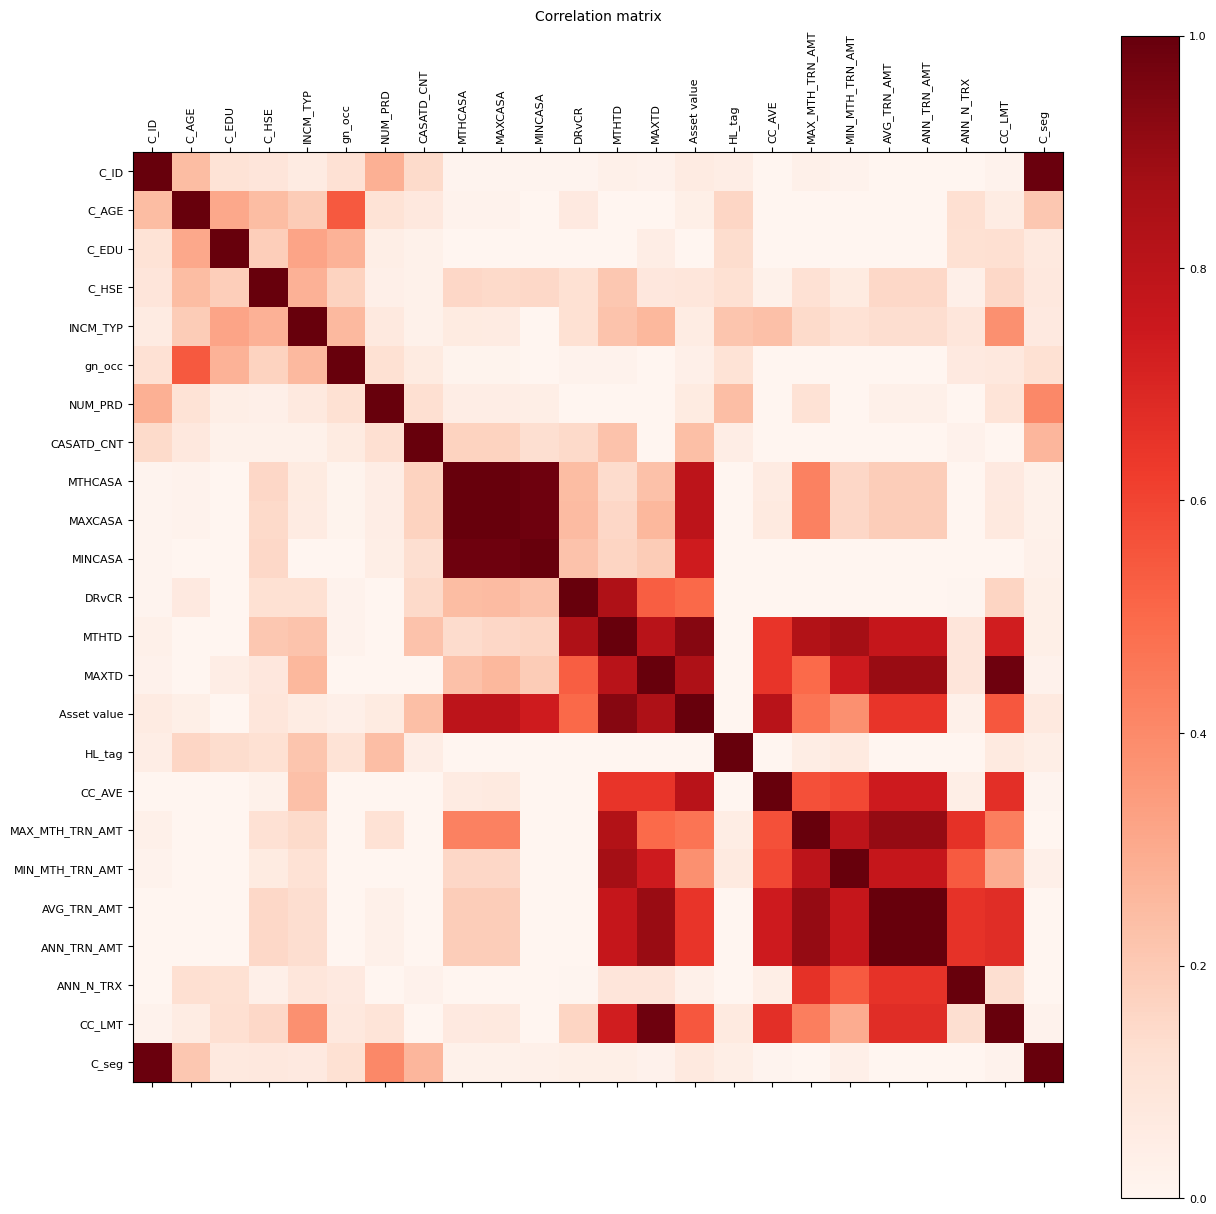

In [75]:
# explore overall correlations
df_corr = df_raw.loc[:, [c for c in df_raw.columns if c not in ["AL_tag", "pur_price_avg", "UT_AVE", "MAXUT", "N_FUNDS"]]]
phik_overview = df_corr.phik_matrix(interval_cols=interval_cols)
f = plt.figure(figsize=(15, 15))
plt.matshow(phik_overview, fignum=f.number, cmap="Reds")
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=8, rotation=90)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation matrix', fontsize=10)

In [76]:
# C_seg is relatively more correlated with C_AGE, gn_occ, NUM_PRD, CASATD_CNT

In [77]:
# convert categorical to string
for col in (nominal + ordinal):
    df_raw[col] = df_raw[col].astype(str)

df_raw.head(2)

,C_ID,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,0,65,Masters,EXECUTIVE CONDOMINIUM,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,0.0,0.0,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1,86,O-Levels,PRIVATE CONDOMINIUM,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,0.0,0.0,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT


In [78]:
# After converting, np.nan has been converted to string as well
df_raw.loc[(df_raw.isin(["nan", "NaN", "NA", "Nan", "Nill", "NAN"])).any(axis=1)]


,C_ID,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
2,2,69,A-Levels,nan,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,0.41066,NaN,NaN,64161.74,0.0,0.0,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,3,70,nan,nan,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5397.18000,NaN,NaN,39792.30,0.0,0.0,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,4,72,O-Levels,EXECUTIVE CONDOMINIUM,nan,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3607.58000,NaN,NaN,67258.47,0.0,0.0,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
5,5,69,nan,nan,nan,RETIREE,3,1.0,79945.77,79945.77,79945.77,26.70592,NaN,NaN,129945.77,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
6,6,72,nan,nan,nan,RETIREE,5,2.0,10662.29,10652.39,9.90,25290.15000,NaN,NaN,35584.40,0.0,0.0,NaN,24936.747500,25949.96,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66077,66077,32,nan,nan,nan,PMEB,2,1.0,952.17,952.17,952.17,NaN,NaN,NaN,952.17,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NORMAL
66078,66078,41,nan,nan,nan,BLUE COLLAR,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL
66079,66079,39,nan,nan,4.0,PMEB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL
66080,66080,50,nan,nan,6.0,PMEB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,1.0,285999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL


In [79]:
# map string back to np.nan
df_raw.replace({"nan": np.nan, "NaN": np.nan, "NAN": np.nan}, inplace=True)

In [80]:
df_raw.head()

,C_ID,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,0,65,Masters,EXECUTIVE CONDOMINIUM,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,0.0,0.0,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1,86,O-Levels,PRIVATE CONDOMINIUM,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,0.0,0.0,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,2,69,A-Levels,NaN,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,4.106600e-01,NaN,NaN,64161.74,0.0,0.0,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,3,70,NaN,NaN,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5.397180e+03,NaN,NaN,39792.30,0.0,0.0,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,4,72,O-Levels,EXECUTIVE CONDOMINIUM,NaN,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3.607580e+03,NaN,NaN,67258.47,0.0,0.0,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT


In [81]:
# prepare list of features for feature engineering
counts = [
    "NUM_PRD",
    "CASATD_CNT",
    "N_FUNDS",
    "ANN_N_TRX",
    ]

values = [
    "MTHCASA",
    "MAXCASA",
    "MINCASA",
    "pur_price_avg",
    "UT_AVE",
    "MAXUT",
    "CC_AVE",
    "MAX_MTH_TRN_AMT",
    "MIN_MTH_TRN_AMT",
    "MTHTD",
    "MAXTD",
    "Asset value",
    "AVG_TRN_AMT",
    "ANN_TRN_AMT",
    "CC_LMT",
    ]

# show the numeric columns not included in feature engineering list
[col for col in df_raw.columns if ((df_raw[col].dtype != "O") and (col not in counts + values))]

['C_ID', 'C_AGE', 'DRvCR']

In [82]:
df_raw.head()

,C_ID,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,0,65,Masters,EXECUTIVE CONDOMINIUM,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,0.0,0.0,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1,86,O-Levels,PRIVATE CONDOMINIUM,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,0.0,0.0,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,2,69,A-Levels,NaN,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,4.106600e-01,NaN,NaN,64161.74,0.0,0.0,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,3,70,NaN,NaN,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5.397180e+03,NaN,NaN,39792.30,0.0,0.0,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,4,72,O-Levels,EXECUTIVE CONDOMINIUM,NaN,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3.607580e+03,NaN,NaN,67258.47,0.0,0.0,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT


In [83]:
# prepare df for standardization
stand_cols = counts + values + ['C_AGE', 'DRvCR']
df_stand = df_raw.loc[:, stand_cols]
df_raw.drop(stand_cols, axis=1, inplace=True)
df_stand.head()

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR
0,3,8.0,NaN,NaN,6896.91,4899.08,910.88,NaN,NaN,NaN,13.233333,NaN,NaN,105000.00,25000.00,111896.91,NaN,NaN,34500.0,65,1.020768e+06
1,4,13.0,NaN,88.0,51714.78,35740.55,1318.25,NaN,NaN,NaN,727.629167,8530.88,273.44,575571.97,135026.15,627286.75,2296.713333,27560.56,4000.0,86,8.326420e+00
2,4,1.0,1.0,78.0,5420.09,5420.09,5420.09,NaN,58424.550000,59600.88,367.389167,523.35,122.13,NaN,NaN,64161.74,283.580833,3402.97,5000.0,69,4.106600e-01
3,3,1.0,1.0,NaN,13596.65,13596.65,13596.65,NaN,28863.181667,33902.58,NaN,NaN,NaN,NaN,NaN,39792.30,NaN,NaN,0.0,70,5.397180e+03
4,4,2.0,1.0,NaN,51639.18,32689.93,18949.25,NaN,15060.339167,15619.29,NaN,NaN,NaN,NaN,NaN,67258.47,NaN,NaN,0.0,72,3.607580e+03


In [84]:
# standardize features
scaler = StandardScaler()
feature_arr = scaler.fit_transform(df_stand.values)
df_stand = pd.DataFrame(feature_arr, index=df_stand.index, columns=df_stand.columns)

df_raw = pd.concat([df_raw, df_stand], axis=1)
display("after scaling", df_raw.head())

'after scaling'

,C_ID,C_EDU,C_HSE,INCM_TYP,gn_occ,HL_tag,AL_tag,C_seg,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR
0,0,Masters,EXECUTIVE CONDOMINIUM,6.0,PMEB,0.0,0.0,AFFLUENT,0.825212,4.444256,NaN,NaN,-0.138387,-0.162113,-0.225299,NaN,NaN,NaN,-0.283094,NaN,NaN,-0.014392,-0.363364,0.653098,NaN,NaN,2.200533,0.882655,7.399066
1,1,O-Levels,PRIVATE CONDOMINIUM,2.0,PMEB,0.0,0.0,AFFLUENT,1.740064,7.987115,NaN,0.269626,0.532190,0.311976,-0.217816,NaN,NaN,NaN,-0.140692,0.717332,-0.106335,2.643474,0.579781,5.091953,0.538457,0.538457,-0.106521,2.348794,-0.275349
2,2,A-Levels,NaN,3.0,PMEB,0.0,0.0,AFFLUENT,1.740064,-0.515746,-0.486491,0.152789,-0.160484,-0.154104,-0.142468,NaN,0.234981,0.122657,-0.212499,-0.287236,-0.253505,NaN,NaN,0.241973,-0.209854,-0.209854,-0.030880,1.161920,-0.275409
3,3,NaN,NaN,2.0,RETIREE,0.0,0.0,AFFLUENT,0.825212,-0.515746,-0.486491,NaN,-0.038144,-0.028416,0.007729,NaN,-0.307797,-0.295947,NaN,NaN,NaN,NaN,NaN,0.032088,NaN,NaN,-0.409085,1.231736,-0.234834
4,4,O-Levels,EXECUTIVE CONDOMINIUM,NaN,BLUE COLLAR,0.0,0.0,AFFLUENT,1.740064,0.192826,-0.486491,NaN,0.531059,0.265083,0.106053,NaN,-0.561232,-0.593767,NaN,NaN,NaN,NaN,NaN,0.268644,NaN,NaN,-0.409085,1.371368,-0.248289


In [85]:
# pd.set_option('display.max_rows', None)
# # check avail transform
# ft.list_primitives()[ft.list_primitives().type == "transform"]

In [86]:
values

['MTHCASA',
 'MAXCASA',
 'MINCASA',
 'pur_price_avg',
 'UT_AVE',
 'MAXUT',
 'CC_AVE',
 'MAX_MTH_TRN_AMT',
 'MIN_MTH_TRN_AMT',
 'MTHTD',
 'MAXTD',
 'Asset value',
 'AVG_TRN_AMT',
 'ANN_TRN_AMT',
 'CC_LMT']

In [87]:
# feature engineering 1
es = ft.EntitySet(id='ft')
es = es.add_dataframe(dataframe_name="ft", dataframe=df_raw.loc[:, values + [index_col]], index=index_col)

features_matrix,feature_names = ft.dfs(
    entityset=es,
    target_dataframe_name='ft',
    trans_primitives=["add_numeric", "subtract_numeric", "divide_numeric",'multiply_numeric'],
    max_depth=2,
    verbose=True)

features_matrix.reset_index(inplace=True)
features_matrix = features_matrix.drop(values, axis=1)

df_raw = df_raw.merge(features_matrix, how='left', on=index_col)

df_raw.head()

Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created


Built 540 features
Elapsed: 00:00 | Progress: 100%|██████████


,C_ID,C_EDU,C_HSE,INCM_TYP,gn_occ,HL_tag,AL_tag,C_seg,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_a

In [88]:
# feature engineering 2
es = ft.EntitySet(id='ft')
es = es.add_dataframe(dataframe_name="ft", dataframe=df_raw.loc[:, counts + [index_col]], index=index_col)

features_matrix,feature_names = ft.dfs(
    entityset=es,
    target_dataframe_name='ft',
    trans_primitives=["add_numeric", "subtract_numeric", "divide_numeric",'multiply_numeric'],
    max_depth=2,
    verbose=True)

features_matrix.reset_index(inplace=True)
features_matrix = features_matrix.drop(counts, axis=1)

df_raw = df_raw.merge(features_matrix, how='left', on=index_col)

df_raw.head()

Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created


Built 34 features
Elapsed: 00:00 | Progress: 100%|██████████


,C_ID,C_EDU,C_HSE,INCM_TYP,gn_occ,HL_tag,AL_tag,C_seg,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_a

In [89]:
df_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

In [90]:
# drop the customer_id
df_X = df_raw.drop([index_col, target_name], axis=1)
df_y = df_raw.loc[:, [target_name]]

In [91]:
# train, val, test split
X, X_test, y, y_test = train_test_split(df_X, df_y, test_size=0.1, random_state=1, shuffle=True, stratify=df_y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)

display(f"train set size: {X_train.shape}, val set size: {X_val.shape}, test set size: {X_test.shape}")

'train set size: (53526, 582), val set size: (5948, 582), test set size: (6609, 582)'

In [92]:
# get cols requiring onehotencoding
categorical = [col for col in (ordinal + nominal) if col != target_name]
display(f"the categorical variables that need one hot encoding are: {categorical}")

# apply onehotencoding for categorical variables
enc = OneHotEncoder(handle_unknown='error', sparse_output=False, drop=None)
enc.fit_transform(df_X.loc[:, categorical])
feature_labels = enc.get_feature_names_out()


feature_arr = enc.transform(X[categorical])
cat_X = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
X = pd.concat([X.drop(categorical, axis=1).reset_index(drop=True), cat_X], axis=1)

# for training data
feature_arr = enc.transform(X_train[categorical])
cat_train = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
X_train = pd.concat([X_train.drop(categorical, axis=1).reset_index(drop=True), cat_train], axis=1)
display("training data after onehot encoding:", X_train.head())

feature_arr = enc.transform(X_val[categorical])
cat_val = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
X_val = pd.concat([X_val.drop(categorical, axis=1).reset_index(drop=True), cat_val], axis=1)
display("val data after onehot encoding:", X_val.head())

feature_arr = enc.transform(X_test[categorical])
cat_test = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
X_test = pd.concat([X_test.drop(categorical, axis=1).reset_index(drop=True), cat_test], axis=1)
display("test data after onehot encoding:", X_test.head())

"the categorical variables that need one hot encoding are: ['INCM_TYP', 'C_EDU', 'C_HSE', 'gn_occ', 'HL_tag', 'AL_tag']"

'training data after onehot encoding:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

'val data after onehot encoding:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

'test data after onehot encoding:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

In [93]:
# impute missing predictor values with np.nan, so that XGBoost will handle them
X = X.replace(np.nan)
X_train = X_train.replace(np.nan)
X_val = X_val.replace(np.nan)
X_test = X_test.replace(np.nan)

In [94]:
# onehotencoder will encode the np.nan into a new column
nan_cols = [col for col in X.columns if "_nan" in col]
nan_cols

['INCM_TYP_nan', 'C_EDU_nan', 'C_HSE_nan', 'gn_occ_nan']

In [95]:
# as onehot add extra nan column, so we need to remove it
def impute_encoded_col(df: pd.DataFrame, col_lst: list) -> pd.DataFrame:
    for col_n in col_lst:
        key = col_n[:-4]
        index =(df.loc[df[col_n] == 1]).index

        # drop column
        df.drop(col_n, axis=1, inplace=True)

        # impute with np.nan
        df.loc[index, [col for col in df.columns if key in col]] = np.nan

    return df

X = impute_encoded_col(X, nan_cols)

X_train = impute_encoded_col(X_train, nan_cols)
display("train set after imputing:", X_train.sample(1))

X_val = impute_encoded_col(X_val, nan_cols)
display("val set after imputing:", X_val.sample(1))

X_test = impute_encoded_col(X_test, nan_cols)
display("test set after imputing:", X_test.sample(1))

'train set after imputing:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

'val set after imputing:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

'test set after imputing:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

In [96]:
# # try to drop useless columns based on feature selection
useless = ['C_HSE_OFFICE',
 'ANN_TRN_AMT / AVG_TRN_AMT',
 'C_HSE_COMMERICAL BUILDING',
 'AVG_TRN_AMT / ANN_TRN_AMT',
 'C_HSE_INDUSTRIAL BUILDING',
 'C_HSE_HOTEL/ SERVICE APARTMENT']

X.drop(useless, axis = 1, inplace=True)
X_train.drop(useless, axis = 1, inplace=True)
X_val.drop(useless, axis = 1, inplace=True)
X_test.drop(useless, axis = 1, inplace=True)

In [97]:
# label encoding for target variable
le = preprocessing.LabelEncoder()

y = pd.DataFrame(le.fit_transform(y[target_name]), columns=["Y"])

y_train = pd.DataFrame(le.transform(y_train[target_name]), columns=["Y"])
display("training after label encoding:", y_train.head())

y_val = pd.DataFrame(le.transform(y_val[target_name]), columns=["Y"])
display("y_val after label encoding:", y_val.head())

y_test = pd.DataFrame(le.transform(y_test[target_name]), columns=["Y"])
display("y_test after label encoding:", y_test.head())

'training after label encoding:'

,Y
0,1
1,1
2,1
3,1
4,0


'y_val after label encoding:'

,Y
0,1
1,1
2,1
3,0
4,1


'y_test after label encoding:'

,Y
0,1
1,1
2,1
3,0
4,1


In [98]:
y_train.values == 0

array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

In [99]:
# calculate sample weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# parameters
objective='binary:logistic'
booster = "gbtree"
eval_metric="logloss"
early_stopping_rounds = 5

In [100]:
%%time

# Finetune Hyperparameters
params = {
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
    "gamma": uniform(0.3, 0.7),
    "max_depth": [8, 9, 10, 11, 12],
    "n_estimators": randint(30, 80),
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "min_child_weight": [1, 1.5, 2, 2.5],
    "eta": [0.3, 0.1, 0.05],
}

k = StratifiedKFold(n_splits=3, shuffle=False)
scoring="f1"

cv_model = xgb.XGBClassifier(
    objective=objective,
    tree_method= "auto",
    eval_metric=eval_metric,
    booster = booster)

search = RandomizedSearchCV(
    cv_model,
    param_distributions=params,
    scoring=scoring,
    random_state=1,
    n_iter=1,  # No. of combinations / fold
    cv=k,
    verbose=1,
    n_jobs=1,
    return_train_score=True,
    refit=False,  # refit by manual as we need to plot the train-val curve to see overfitting problem
    )

search.fit(X_train, y_train, sample_weight=sample_weights)
cv_results =  pd.DataFrame(search.cv_results_).loc[:, ["rank_test_score", "mean_test_score", "params"]].sort_values(by=["rank_test_score"])
cv_results.head(5)

# show the best set of hyperparams
search.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/sklearn.py", line 1496, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [14:09:00] /Users/runner/work/xgboost/xgboost/src/common/quantile.cc:94: Check failed: h_weights.size() == batch.Size() (6 vs. 35684) : Invalid size of sample weight.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000177af8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000177b5d224 void xgboost::common::HostSketchContainer::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::MetaInfo const&, float) + 380
  [bt] (2) 3   libxgboost.dylib                    0x0000000177bea100 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 6008
  [bt] (3) 4   libxgboost.dylib                    0x0000000177be8330 xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1072
  [bt] (4) 5   libxgboost.dylib                    0x0000000177ba63e4 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 140
  [bt] (5) 6   libxgboost.dylib                    0x0000000177b024b0 XGQuantileDMatrixCreateFromCallback + 516
  [bt] (6) 7   libffi.8.dylib                      0x00000001049bc04c ffi_call_SYSV + 76
  [bt] (7) 8   libffi.8.dylib                      0x00000001049b9834 ffi_call_int + 1404
  [bt] (8) 9   _ctypes.cpython-38-darwin.so        0x00000001049f40ac _ctypes_callproc + 856



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/sklearn.py", line 1496, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/kewenyang/anaconda3/envs/insights/lib/python3.8/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [14:09:01] /Users/runner/work/xgboost/xgboost/src/common/quantile.cc:94: Check failed: h_weights.size() == batch.Size() (6 vs. 35684) : Invalid size of sample weight.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000177af8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000177b5d224 void xgboost::common::HostSketchContainer::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::MetaInfo const&, float) + 380
  [bt] (2) 3   libxgboost.dylib                    0x0000000177bea100 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 6008
  [bt] (3) 4   libxgboost.dylib                    0x0000000177be8330 xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1072
  [bt] (4) 5   libxgboost.dylib                    0x0000000177ba63e4 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 140
  [bt] (5) 6   libxgboost.dylib                    0x0000000177b024b0 XGQuantileDMatrixCreateFromCallback + 516
  [bt] (6) 7   libffi.8.dylib                      0x00000001049bc04c ffi_call_SYSV + 76
  [bt] (7) 8   libffi.8.dylib                      0x00000001049b9834 ffi_call_int + 1404
  [bt] (8) 9   _ctypes.cpython-38-darwin.so        0x00000001049f40ac _ctypes_callproc + 856




[0]	validation_0-logloss:0.55194	validation_1-logloss:0.57328
[1]	validation_0-logloss:0.46572	validation_1-logloss:0.50287
[2]	validation_0-logloss:0.40540	validation_1-logloss:0.45855
[3]	validation_0-logloss:0.36674	validation_1-logloss:0.43229
[4]	validation_0-logloss:0.33524	validation_1-logloss:0.41417
[5]	validation_0-logloss:0.30907	validation_1-logloss:0.39984
[6]	validation_0-logloss:0.28995	validation_1-logloss:0.39018
[7]	validation_0-logloss:0.26929	validation_1-logloss:0.38064
[8]	validation_0-logloss:0.25397	validation_1-logloss:0.37567
[9]	validation_0-logloss:0.24281	validation_1-logloss:0.37264
[10]	validation_0-logloss:0.22966	validation_1-logloss:0.36803
[11]	validation_0-logloss:0.22098	validation_1-logloss:0.36469
[12]	validation_0-logloss:0.20900	validation_1-logloss:0.36236
[13]	validation_0-logloss:0.20083	validation_1-logloss:0.35999
[14]	validation_0-logloss:0.19273	validation_1-logloss:0.35702
[15]	validation_0-logloss:0.18497	validation_1-logloss:0.35631
[1

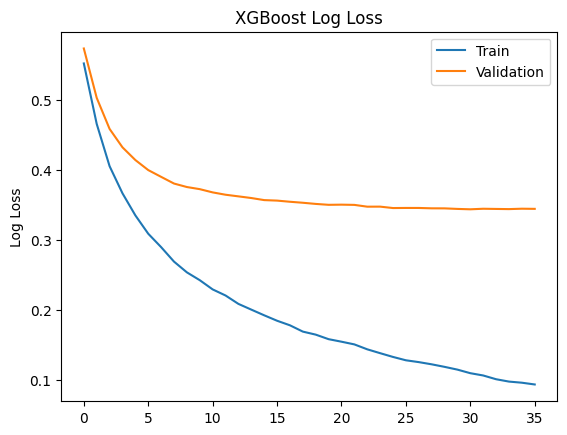

In [44]:
# plot train-val curve to ensure no overfitting
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

colsample_bytree = 0.6
n_estimators = 69
tree_method= "auto"

# tuning parameters
eta = 0.3
max_depth = 10
max_leaves = 2 ** max_depth

# prevent overfitting
min_child_weight = 1.5
gamma = 0.45095519663195377
subsample = 0.9


# Use "hist" for constructing the trees, with early stopping enabled.
model = xgb.XGBClassifier(
    early_stopping_rounds=early_stopping_rounds,
    tree_method=tree_method,
    objective=objective,
    n_estimators=n_estimators,
    missing=np.nan,
    eval_metric=eval_metric,
    booster=booster,
    eta=eta,
    max_depth=max_depth,
    max_leaves=max_leaves,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree)

# Fit the model, val sets are used for early stopping.
result = model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], sample_weight=sample_weights, verbose=True)

# check overfitting
results = result.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [45]:
# Threshold Moving/Tuning
from numpy import arange
from numpy import argmax

yhat = model.predict_proba(X_val)

# keep probabilities for the positive outcome only
probs = yhat[:, 1]

# define thresholds
thresholds = arange(0, 1, 0.001)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# evaluate each threshold
scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)

best_thresh = thresholds[ix]

print('Best performing threshold=%.3f with best F-Score=%.5f' % (best_thresh, scores[ix]))

Best performing threshold=0.146 with best F-Score=0.92450


In [46]:
# finally train with all traing + val, and change to dart booster
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y
)

colsample_bytree = 0.6
n_estimators = 69
tree_method= "auto"
# booster = "dart"  # update booster to dart
booster = "gbtree"

# tuning parameters
eta = 0.3
max_depth = 10
max_leaves = 2**max_depth

# prevent overfitting
min_child_weight = 1.5
gamma = 0.45095519663195377
subsample = 0.9


# Use "hist" for constructing the trees, with early stopping enabled.
model = xgb.XGBClassifier(
    tree_method=tree_method,
    objective=objective,
    n_estimators=n_estimators,
    missing=np.nan,
    eval_metric=eval_metric,
    booster=booster,
    eta=eta,
    max_depth=max_depth,
    max_leaves=max_leaves,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree)

model.fit(X, y, verbose=True, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              feature_types=None, gamma=0.45095519663195377, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=1024, min_child_weight=1.5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=69,
              n_jobs=None, num_parallel_tree=None, ...)

In [47]:
# train
preds = model.predict(X_train)

# 0.9130316495873766
f1_score(y_train, preds)

0.9243160889924495

In [48]:
# val
preds = model.predict(X_val)

# 0.9130316495873766
f1_score(y_val, preds)

0.9250225835591689

In [49]:
# predict on test set
preds = model.predict(X_test)

# 0.9196223751544026
f1_score(y_test, preds)

0.9157827939443387

In [50]:
# predict on test set
prob = model.predict_proba(X_test)[:, 1]

preds = (prob > best_thresh).astype("int")

# 0.9228875406664908
f1_score(y_test, preds)

0.9213966288269695

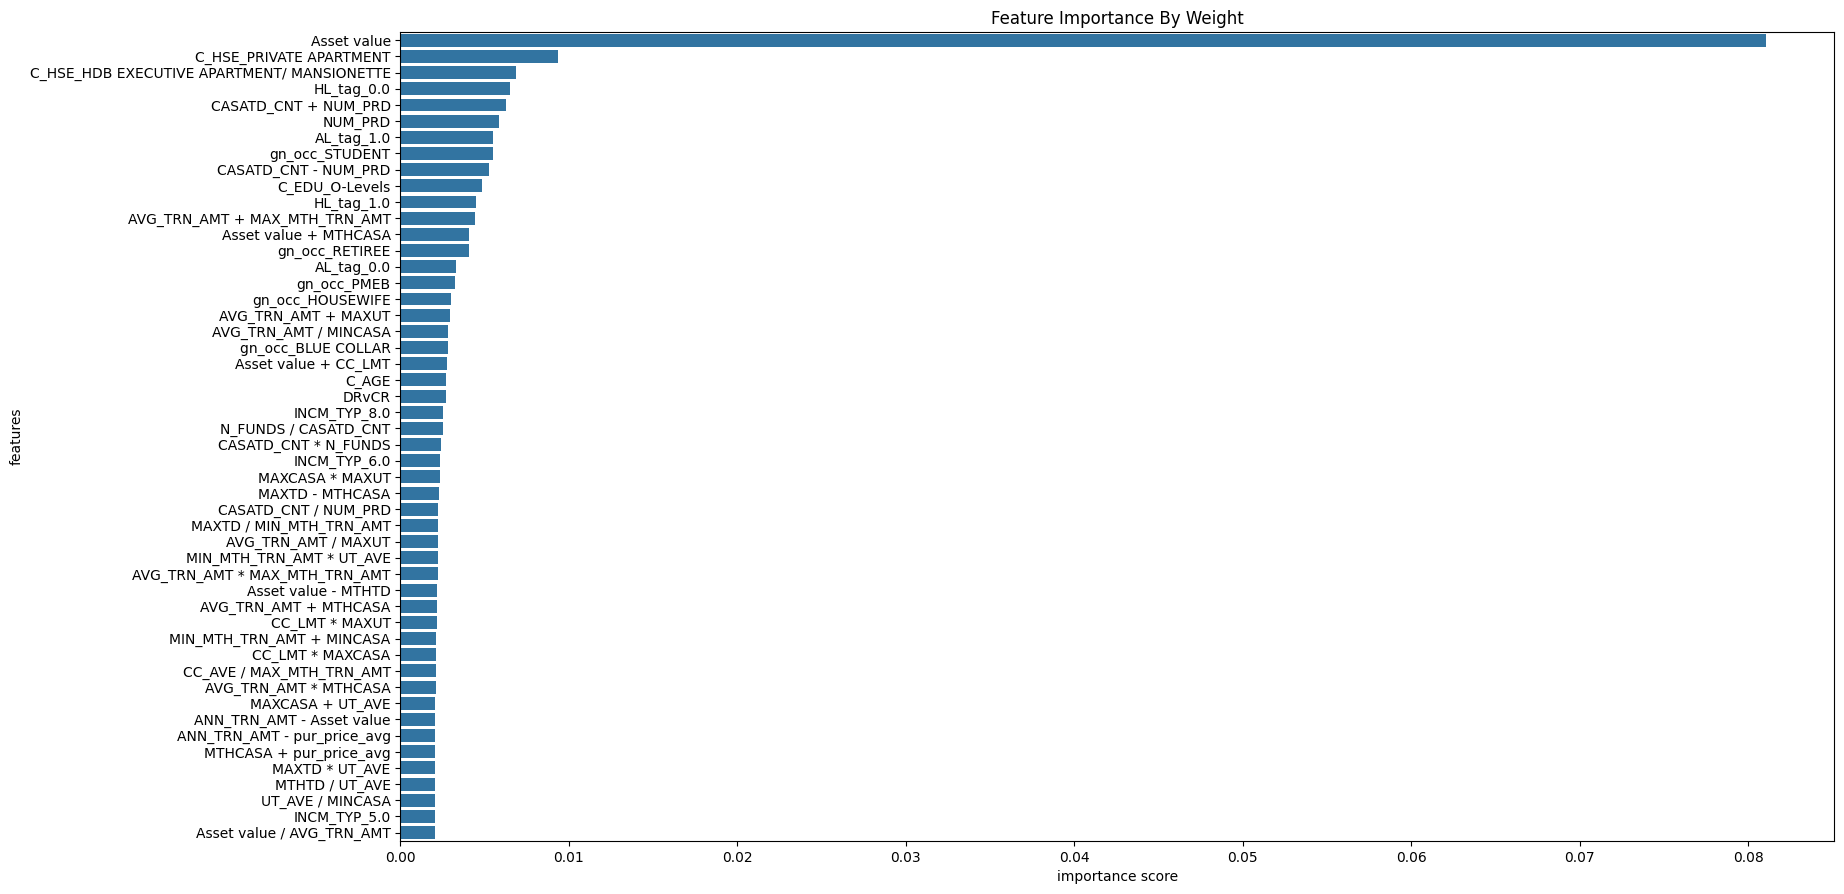

In [51]:
# plot the feature importance
feature_imp = pd.DataFrame(sorted(zip(model.feature_names_in_, model.feature_importances_), key=lambda x: x[0], reverse=True), columns=['Feature', 'Value'])
fig, ax = plt.subplots()

data = feature_imp.sort_values(by="Value", ascending=False).head(50)
fig.set_size_inches(18.5, 10.5)

sns.barplot(x="Value", y="Feature", data=data)
ax.set_title('Feature Importance By Weight')
ax.set_xlabel('importance score')
ax.set_ylabel('features')
ax.yaxis.set_visible(True)
ax.xaxis.set_visible(True)
fig.patch.set_facecolor('white')
# plt.savefig(f'../data/feature_importance_by_weight.png', bbox_inches='tight')

In [52]:
# get the useless col in prediction
useless_cols = feature_imp.sort_values(by="Value", ascending=False).loc[feature_imp.sort_values(by="Value", ascending=False).Value == 0, "Feature"].tolist()
useless_cols

['C_HSE_SHOPHOUSE', 'C_EDU_Professional Qualifications']

In [53]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

[14:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


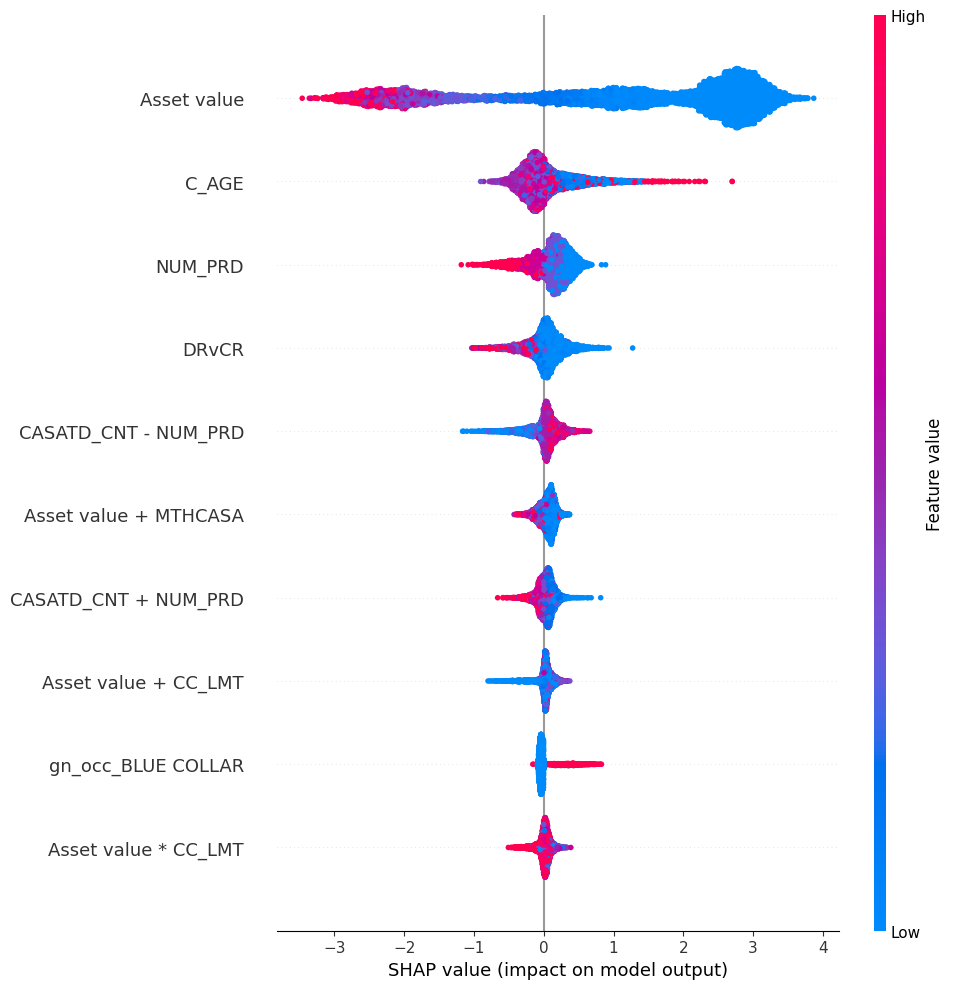

In [54]:
shap.summary_plot(shap_values.values, X_test, max_display=10, show=False, plot_type="dot", plot_size=[10,10])


In [55]:
"""
After all the analysis, we have built the end to end pipeline for production
"""

'\nAfter all the analysis, we have built the end to end pipeline for production\n'

In [57]:
# run pipeline
df_raw = pd.read_excel("/Users/kewenyang/Documents/GitHub/Maybank_Classification/data/Assessment.xlsx",
                       engine='openpyxl',
                       sheet_name=1)

pipe = E2EPipeline()
data = pipe.preprocess(df_raw)
f1 = pipe.train(data)
print(f"the f1 score is: {f1}")

Built 540 features
Elapsed: 00:00 | Progress: 100%|██████████

Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created



Built 34 features
Elapsed: 00:00 | Progress: 100%|██████████
[src.util.logger: 2024-03-25 14:03:02, INFO] - train set size: (53526, 582), val set size:                     (5948, 582), test set size: (6609, 582)
[src.util.logger: 2024-03-25 14:03:02, INFO] - the categorical variables that need one hot                     encoding are: ['INCM_TYP', 'C_EDU', 'C_HSE', 'gn_occ', 'HL_tag', 'AL_tag']
the f1 score is: 0.9228875406664908
